In [2]:
import yfinance            as yf
import pandas              as pd
import numpy               as np
from sklearn.linear_model  import Lasso
from sklearn.model_selection import train_test_split

np.random.seed(69)

doge_raw = yf.Ticker("DOGE-USD").history(period="30y")

doge = doge_raw['Close']
doge

Date
2017-11-09    0.001415
2017-11-10    0.001163
2017-11-11    0.001201
2017-11-12    0.001038
2017-11-13    0.001211
                ...   
2022-08-08    0.070055
2022-08-09    0.069125
2022-08-10    0.071195
2022-08-11    0.070930
2022-08-12    0.071039
Name: Close, Length: 1738, dtype: float64

In [5]:
features = pd.DataFrame(doge.copy())
features['SMA_10'] = features['Close'].rolling(10).mean()
features['SMA_50'] = features['Close'].rolling(50).mean()
features['SMA_100'] = features['Close'].rolling(100).mean()
features['STD_14'] = features['Close'].pct_change().rolling(14).std()
features['Vol_Mean_20'] = doge_raw['Volume'].rolling(20).std()
features['Fake_Macro'] = np.random.rand(len(doge), 1)
features['Ret'] = features['Close'].pct_change().dropna()
features = features.drop('Close',axis=1)
features = features.dropna()

X_train, X_test, y_train, y_test = train_test_split(features.drop('Ret',axis=1), features['Ret'], test_size=0.3, shuffle=False)
    
    
model = Lasso().fit(X_train, y_train)  # ideally we would use LassoCV but i cbf to build out the time series CVs today haha

forecasts = model.predict(X_test) # im also not tuning any params or anything fancy, this is just a demo

model.score(X_test,y_test) # not great lol

-0.38739445474037226

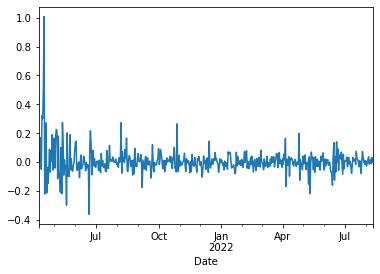

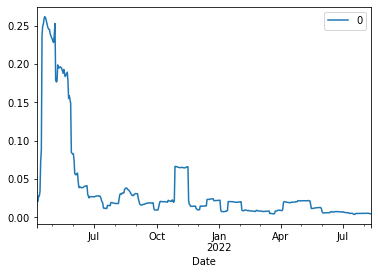

In [6]:
y_test.plot()
pd.DataFrame(forecasts, index = y_test.index).plot()

In [7]:
pd.DataFrame(forecasts, index = y_test.index).describe()

,0
count,492.000000
mean,0.036701
std,0.057250
min,0.003794
25%,0.008577
50%,0.019264
75%,0.027602
max,0.261675


In [12]:
sigs = []

for i in forecasts:
    if i >= 0.027696:
        sigs.append(1)
    else:
        sigs.append(0)

In [13]:
def backtester(signals,price, tcost = 0.005):

        pos_val = np.zeros(np.shape(price))
        cash    = np.zeros(np.shape(price))
        cash[0] = 1

        for i,val in enumerate(price):

            if i == len(price)-1:
                break


            if signals[i] == 0:

                cash[i+1] = (pos_val[i] * val * (1-tcost)) + cash[i]
                pos_val[i+1] = 0

            elif signals[i] == 1:

                pos_val[i+1] = (cash[i] / val)*((1-tcost)) + pos_val[i]
                cash[i+1] = 0


        returns = [a*b for a,b in zip(pos_val,price)] + cash
        
        return pd.DataFrame(returns, index = price.index)
    
def win_rate(sigs, returns):
    
    """
    Signals : series
    returns : series
    must be same length
    """
    
    tps = []

    sigs = sigs[1:-1].values.ravel()

    rets = (returns.pct_change()).shift(1).dropna().values.ravel()

    for i,val in enumerate(sigs):

        if (sigs[i] == 1 and rets[i]>0):
            tps.append(1)

    win_rate = sum(tps)/len(sigs)
    return win_rate

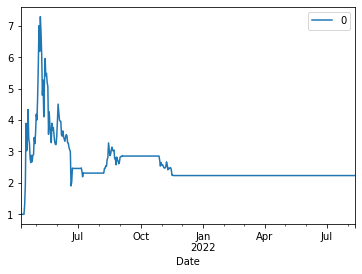

In [14]:
strat_ret = backtester(pd.Series(sigs),doge[y_test.index[0]:])

strat_ret.plot()

In [15]:
win_rate(pd.Series(sigs),strat_ret)

0.11020408163265306